In [1]:
import sys
print(sys.executable)

/home/disk/p/wycheng/anaconda3/envs/tensorflow/bin/python


In [2]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time

# Set Countries Boundaries

In [3]:
import regionmask
import geopandas as gpd

In [4]:
PATH_TO_SHAPEFILE = '/home/disk/eos10/wycheng/LightningMachineLearning/data/WorldCountriesBoundaries/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp'
countries = gpd.read_file(PATH_TO_SHAPEFILE)

In [5]:
indexes = np.arange(250).tolist()
countries_mask_poly = regionmask.Regions(name = 'COUNTRY', numbers = indexes, names = countries.CNTRY_NAME[indexes], abbrevs = countries.CNTRY_NAME[indexes], outlines = list(countries.geometry.values[i] for i in range(0,countries.shape[0])))
mask = countries_mask_poly.mask(dataset_raw['F'].isel(Time = 0), lat_name='lat', lon_name='lon')
mask = mask.where( (mask==232) & (mask.lat<49.35) & (mask.lat>24.74)  & (mask.lon>-124.78) & (mask.lon<-66.95) )

NameError: name 'dataset_raw' is not defined

# Read data

In [6]:
WWLLN_dataset = xr.open_mfdataset('/home/disk/eos12/wycheng/data/US/WWLLN/WWLLN_*_F_cg_1deg3hr_US.nc',
                                  parallel=True,
                                  chunks={'Time':'auto', 'lat':'auto', 'lon':'auto'})
WWLLN_dataset['F'] = (1/((111.19492664455873)**2)) * (365.25*8) * WWLLN_dataset['F']
display(WWLLN_dataset)

<xarray.Dataset>
Dimensions:  (Time: 29216, lat: 40, lon: 75)
Coordinates:
  * Time     (Time) datetime64[ns] 2010-01-01 ... 2019-12-31T21:00:00
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 55.5 56.5 57.5 58.5 59.5
  * lon      (lon) float32 -134.5 -133.5 -132.5 -131.5 ... -62.5 -61.5 -60.5
Data variables:
    F        (Time, lat, lon) float32 dask.array<chunksize=(2920, 40, 75), meta=np.ndarray>
Attributes:
    creation_date:  Sat Mar  6 22:09:14 PST 2021
    Conventions:    None
    title:          level 1 analysis

In [7]:
TRMM_dataset = xr.open_mfdataset('/home/disk/eos12/wycheng/data/US/TRMM/TRMM_*_pcp_cg_1deg3hr_US.nc',
                                  parallel=True,
                                  chunks={'Time':'auto', 'lat':'auto', 'lon':'auto'})
TRMM_dataset['pcp'] = TRMM_dataset['pcp'].where(TRMM_dataset['pcp']>0,0)
display(TRMM_dataset)

<xarray.Dataset>
Dimensions:  (Time: 29216, lat: 40, lon: 75)
Coordinates:
  * Time     (Time) datetime64[ns] 2010-01-01 ... 2019-12-31T21:00:00
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 55.5 56.5 57.5 58.5 59.5
  * lon      (lon) float32 -134.5 -133.5 -132.5 -131.5 ... -62.5 -61.5 -60.5
Data variables:
    pcp      (Time, lat, lon) float32 dask.array<chunksize=(2920, 40, 75), meta=np.ndarray>

In [9]:
ERA5_cape_dataset = xr.open_dataset('/home/disk/eos12/wycheng/data/US/ERA5/dataset/ERA5_cape_dataset.nc')
display(ERA5_cape_dataset)

<xarray.Dataset>
Dimensions:  (Time: 29216, lat: 40, lon: 75)
Coordinates:
  * Time     (Time) datetime64[ns] 2010-01-01 ... 2019-12-31T21:00:00
  * lon      (lon) float64 -134.5 -133.5 -132.5 -131.5 ... -62.5 -61.5 -60.5
  * lat      (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 55.5 56.5 57.5 58.5 59.5
Data variables:
    cape     (Time, lat, lon) float64 ...

In [10]:
ERA5_t_dataset = xr.open_dataset('/home/disk/eos12/wycheng/data/US/ERA5/dataset/ERA5_t_dataset.nc')
ERA5_q_dataset = xr.open_dataset('/home/disk/eos12/wycheng/data/US/ERA5/dataset/ERA5_q_dataset.nc')
ERA5_z_dataset = xr.open_dataset('/home/disk/eos12/wycheng/data/US/ERA5/dataset/ERA5_z_dataset.nc')

In [12]:
dataset_raw = xr.merge([WWLLN_dataset, TRMM_dataset, ERA5_cape_dataset, ERA5_t_dataset, ERA5_q_dataset, ERA5_z_dataset]).sel(Time=slice("2010-01-01", "2019-12-31")).resample(Time="1D").mean()
dataset_raw = dataset_raw.sel(lat=slice(20,50),lon=slice(-135,-80))
dataset_raw['CP'] = dataset_raw['cape'] * dataset_raw['pcp']
dataset_raw = dataset_raw.assign(TO=lambda dataset_raw: 1.0*(dataset_raw.F>0))
dataset_raw.persist()
display(dataset_raw)

/home/disk/p/wycheng/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/disk/p/wycheng/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/disk/p/wycheng/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/disk/p/wycheng/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/disk/p/wycheng/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value

<xarray.Dataset>
Dimensions:  (Time: 3652, lat: 30, lev: 10, lon: 55)
Coordinates:
  * Time     (Time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
  * lat      (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 45.5 46.5 47.5 48.5 49.5
  * lon      (lon) float32 -134.5 -133.5 -132.5 -131.5 ... -82.5 -81.5 -80.5
  * lev      (lev) int32 1000 900 800 700 600 500 400 300 200 100
Data variables:
    F        (Time, lat, lon) float32 dask.array<chunksize=(1, 30, 55), meta=np.ndarray>
    pcp      (Time, lat, lon) float32 dask.array<chunksize=(1, 30, 55), meta=np.ndarray>
    cape     (Time, lat, lon) float64 23.13 21.49 19.74 ... 3.883 4.19 6.344
    t        (Time, lev, lat, lon) float64 292.9 292.5 292.2 ... 222.1 221.9
    q        (Time, lev, lat, lon) float64 0.01032 0.01005 ... 2.779e-06
    z        (Time, lev, lat, lon) float64 1.526e+03 1.549e+03 ... 1.579e+05
    CP       (Time, lat, lon) float64 dask.array<chunksize=(1, 30, 55), meta=np.ndarray>
    TO       (Time, lat, lon) float64 dask.array<chunksize=(1, 30, 55), meta=np.ndarray>

In [ ]:
dataset_raw.to_netcdf('/home/disk/eos12/wycheng/data/US/dataset/CNN_dataset.nc', mode='w')

# CONUS Mask

In [13]:
indexes = np.arange(250).tolist()
countries_mask_poly = regionmask.Regions(name = 'COUNTRY', numbers = indexes, names = countries.CNTRY_NAME[indexes], abbrevs = countries.CNTRY_NAME[indexes], outlines = list(countries.geometry.values[i] for i in range(0,countries.shape[0])))
mask = countries_mask_poly.mask(WWLLN_dataset.isel(Time = 0), lat_name='lat', lon_name='lon')
mask = mask.where( (mask==232) & (mask.lat<49.35) & (mask.lat>24.74)  & (mask.lon>-124.78) & (mask.lon<-66.95) )

# Plot

/home/disk/p/wycheng/anaconda3/envs/incubator2021/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


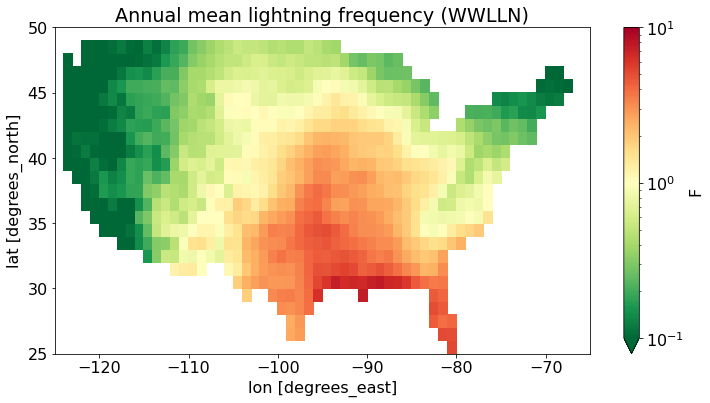

In [10]:
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
WWLLN_dataset['F'].where( ~np.isnan(mask) ).mean(dim='Time').plot(cmap='RdYlGn_r',norm=colors.LogNorm(vmin=0.1, vmax=10))
plt.title('Annual mean lightning frequency (WWLLN)')
plt.xlim([-125,-65])
plt.ylim([25,50])
plt.rcParams.update({'font.size': 10})

In [11]:
WWLLN_dataset = WWLLN_dataset.assign(TO=lambda WWLLN_dataset: 1.0*(WWLLN_dataset.F>0))

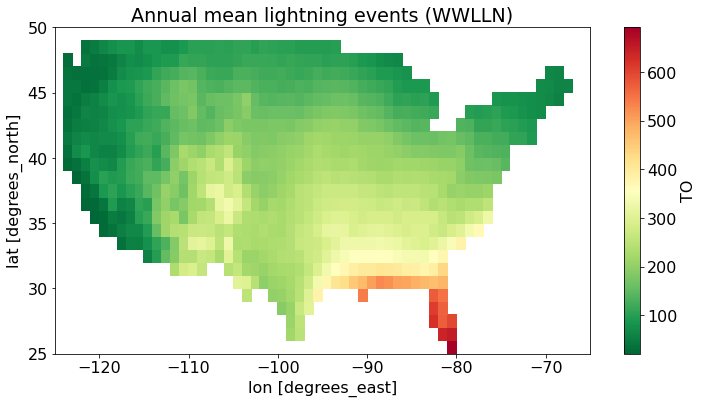

In [12]:
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
(WWLLN_dataset['TO'].sum(dim='Time')/10).where( ~np.isnan(mask) ).plot(cmap='RdYlGn_r')
plt.title('Annual mean lightning events (WWLLN)')
plt.xlim([-125,-65])
plt.ylim([25,50])
plt.rcParams.update({'font.size': 10})

In [17]:
pcp_thrs = 0.01

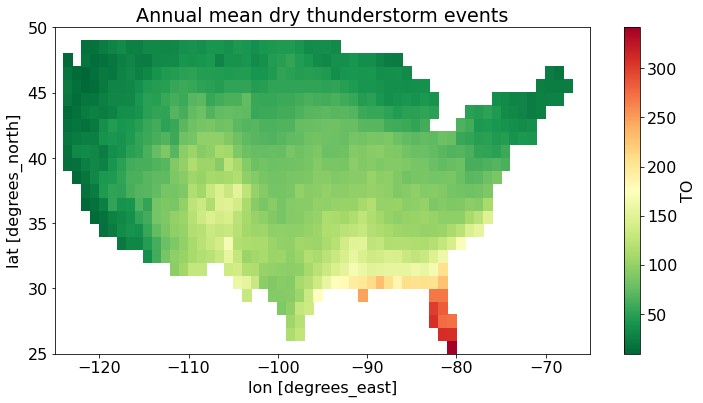

In [14]:
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
(dataset['TO'].where(dataset['pcp']<pcp_thrs).sum(dim='Time')/10).where( ~np.isnan(mask) ).plot(cmap='RdYlGn_r')
plt.title('Annual mean dry thunderstorm events')
plt.xlim([-125,-65])
plt.ylim([25,50])
plt.rcParams.update({'font.size': 10})

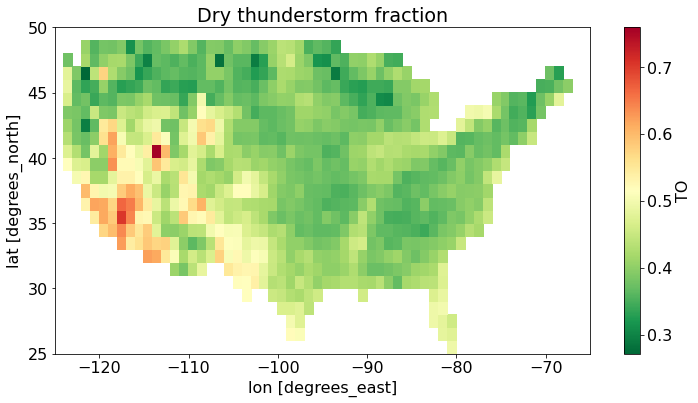

In [16]:
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
(dataset['TO'].where(dataset['pcp']<pcp_thrs).sum(dim='Time')/dataset['TO'].sum(dim='Time')).where( ~np.isnan(mask) ).plot(cmap='RdYlGn_r')
plt.title('Dry thunderstorm fraction')
plt.xlim([-125,-65])
plt.ylim([25,50])
plt.rcParams.update({'font.size': 10})

In [ ]:
date='2019-06-06'